In [2]:
# Get dependencies
import keras
from keras.applications.inception_v3 import decode_predictions, preprocess_input, InceptionV3
import keras.backend as K
from keras.layers import Input
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import tensorflow as tf

os.environ['KERAS_BACKEND'] = 'tensorflow'

ModuleNotFoundError: No module named 'model'

In [10]:
"""
Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

"""Model wrapper for TCAV."""

from abc import ABCMeta
from abc import abstractmethod
import numpy as np
import tensorflow as tf

class ModelWrapper(object):
  """Simple wrapper of the for models with session object for TCAV.

    Supports easy inference with no need to deal with the feed_dicts.
  """
  __metaclass__ = ABCMeta

  @abstractmethod
  def __init__(self):
    # A dictionary of bottleneck tensors.
    self.bottlenecks_tensors = None
    # A dictionary of input, 'logit' and prediction tensors.
    self.ends = None
    # The model name string.
    self.model_name = None
    # a place holder for index of the neuron/class of interest.
    # usually defined under the graph. For example:
    # with g.as_default():
    #   self.tf.placeholder(tf.int64, shape=[None])
    self.y_input = None
    # The tensor representing the loss (used to calculate derivative).
    self.loss = None

  def _make_gradient_tensors(self):
    """Makes gradient tensors for all bottleneck tensors.
    """
    self.bottlenecks_gradients = {}
    for bn in self.bottlenecks_tensors:
      self.bottlenecks_gradients[bn] = tf.gradients(
          self.loss, self.bottlenecks_tensors[bn])[0]

  def get_gradient(self, acts, y, bottleneck_name):
    """Return the gradient of the loss with respect to the bottleneck_name.

    Args:
      acts: activation of the bottleneck
      y: index of the logit layer
      bottleneck_name: name of the bottleneck to get gradient wrt.

    Returns:
      the gradient array.
    """
    return self.sess.run(self.bottlenecks_gradients[bottleneck_name], {
        self.bottlenecks_tensors[bottleneck_name]: acts,
        self.y_input: y
    })

  def get_predictions(self, examples):
    """Get prediction of the examples.

    Args:
      imgs: array of examples to get predictions

    Returns:
      array of predictions
    """
    return self.adjust_prediction(
        self.sess.run(self.ends['prediction'], {self.ends['input']: examples}))

  def adjust_prediction(self, pred_t):
    """Adjust the prediction tensor to be the expected shape.

    Defaults to a no-op, but necessary to override for GoogleNet
    Returns:
      pred_t: pred_tensor.
    """
    return pred_t

  def reshape_activations(self, layer_acts):
    """Reshapes layer activations as needed to feed through the model network.

    Override this for models that require reshaping of the activations for use
    in TCAV.

    Args:
      layer_acts: Activations as returned by run_examples.

    Returns:
      Activations in model-dependent form; the default is a squeezed array (i.e.
      at most one dimensions of size 1).
    """
    return np.asarray(layer_acts).squeeze()

  @abstractmethod
  def label_to_id(self, label):
    """Convert label (string) to index in the logit layer (id)."""
    pass

  @abstractmethod
  def id_to_label(self, idx):
    """Convert index in the logit layer (id) to label (string)."""
    pass

  def run_examples(self, examples, bottleneck_name):
    """Get activations at a bottleneck for provided examples.

    Args:
      examples: example data to feed into network.
      bottleneck_name: string, should be key of self.bottlenecks_tensors

    Returns:
      Activations in the given layer.
    """
    return self.sess.run(self.bottlenecks_tensors[bottleneck_name],
                         {self.ends['input']: examples})


class ImageModelWrapper(ModelWrapper):
  """Wrapper base class for image models."""

  def __init__(self, image_shape):
    super(ModelWrapper, self).__init__()
    # shape of the input image in this model
    self.image_shape = image_shape

  def get_image_shape(self):
    """returns the shape of an input image."""
    return self.image_shape


class PublicImageModelWrapper(ImageModelWrapper):
  """Simple wrapper of the public image models with session object.
  """
  def __init__(self,
               sess,
               model_fn_path,
               labels_path,
               image_shape,
               endpoints_dict,
               scope):
    super(PublicImageModelWrapper, self).__init__(image_shape)
    self.labels = tf.gfile.Open(labels_path).read().splitlines()
    self.ends = PublicImageModelWrapper.import_graph(model_fn_path,
                                                     endpoints_dict,
                                                     self.image_value_range,
                                                     scope=scope)
    self.bottlenecks_tensors = PublicImageModelWrapper.get_bottleneck_tensors(
        scope)
    graph = tf.get_default_graph()

    # Construct gradient ops.
    with graph.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)
      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(
                  self.y_input,
                  self.ends['prediction'].get_shape().as_list()[1]),
              logits=self.pred))
    self._make_gradient_tensors()

  def id_to_label(self, idx):
    return self.labels[idx]

  def label_to_id(self, label):
    return self.labels.index(label)

  @staticmethod
  def create_input(t_input, image_value_range):
    """Create input tensor."""
    def forget_xy(t):
      """Forget sizes of dimensions [1, 2] of a 4d tensor."""
      zero = tf.identity(0)
      return t[:, zero:, zero:, :]

    t_prep_input = t_input
    if len(t_prep_input.shape) == 3:
      t_prep_input = tf.expand_dims(t_prep_input, 0)
    t_prep_input = forget_xy(t_prep_input)
    lo, hi = image_value_range
    t_prep_input = lo + t_prep_input * (hi-lo)
    return t_input, t_prep_input


  # From Alex's code.
  @staticmethod
  def get_bottleneck_tensors(scope):
    """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
    graph = tf.get_default_graph()
    bn_endpoints = {}
    for op in graph.get_operations():
      if op.name.startswith(scope+'/') and 'Concat' in op.type:
        name = op.name.split('/')[1]
        bn_endpoints[name] = op.outputs[0]
    return bn_endpoints

  # Load graph and import into graph used by our session
  @staticmethod
  def import_graph(saved_path, endpoints, image_value_range, scope='import'):
    t_input = tf.placeholder(np.float32, [None, None, None, 3])
    graph = tf.Graph()
    assert graph.unique_name(scope, False) == scope, (
        'Scope "%s" already exists. Provide explicit scope names when '
        'importing multiple instances of the model.') % scope

    #graph_def = tf.GraphDef.FromString(tf.gfile.Open(saved_path).read())
    graph_def = tf.GraphDef.FromString(tf.gfile.Open(saved_path, mode = 'rb').read())

    with tf.name_scope(scope) as sc:
      t_input, t_prep_input = PublicImageModelWrapper.create_input(
          t_input, image_value_range)

      graph_inputs = {}
      graph_inputs[endpoints['input']] = t_prep_input
      myendpoints = tf.import_graph_def(
          graph_def, graph_inputs, endpoints.values(), name=sc)
      myendpoints = dict(zip(endpoints.keys(), myendpoints))
      myendpoints['input'] = t_input
    return myendpoints

class KerasModelWrapper(ImageModelWrapper):
  def __init__(self, sess, label_path, image_shape,
              endpoints_dict, name, image_value_range):
      super(self.__class__, self).__init__(image_shape)
      
      self.sess = sess
      self.labels = tf.gfile.Open(label_path).read().splitlines()
      self.model_name = name
      self.image_value_range = image_value_range

      # get endpoint tensors
      self.ends = {'input': endpoints_dict['input_tensor'], 'prediction': endpoints_dict['prediction_tensor']}
      
      self.bottlenecks_tensors = self.get_bottleneck_tensors()
      
      # load the graph from the backend
      graph = tf.get_default_graph()

      # Construct gradient ops.
      with graph.as_default():
          self.y_input = tf.placeholder(tf.int64, shape=[None])

          self.pred = tf.expand_dims(self.ends['prediction'][0], 0)
          self.loss = tf.reduce_mean(
              tf.nn.softmax_cross_entropy_with_logits_v2(
                  labels=tf.one_hot(
                      self.y_input,
                      self.ends['prediction'].get_shape().as_list()[1]),
                  logits=self.pred))
      self._make_gradient_tensors()

  def id_to_label(self, idx):
      return self.labels[idx]

  def label_to_id(self, label):
      return self.labels.index(label)

  @staticmethod
  def create_input(t_input, image_value_range):
      """Create input tensor."""
      def forget_xy(t):
          """Forget sizes of dimensions [1, 2] of a 4d tensor."""
          zero = tf.identity(0)
          return t[:, zero:, zero:, :]

      t_prep_input = t_input
      if len(t_prep_input.shape) == 3:
          t_prep_input = tf.expand_dims(t_prep_input, 0)
      t_prep_input = forget_xy(t_prep_input)
      lo, hi = image_value_range
      t_prep_input = lo + t_prep_input * (hi-lo)
      return t_input, t_prep_input

  @staticmethod
  def get_bottleneck_tensors():
      """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
      graph = tf.get_default_graph()
      bn_endpoints = {}
      for op in graph.get_operations():
          # change this below string to change which layers are considered bottlenecks
          # use 'ConcatV2' for InceptionV3
          # use 'MaxPool' for VGG16 (for example)
          if 'ConcatV2' in op.type:
              name = op.name.split('/')[0]
              # print(name, op.outputs[0].name)
              bn_endpoints[name] = op.outputs[0]
          
      return bn_endpoints
  

In [ ]:
sess = K.get_session()

In [12]:
base_path = os.getcwd()
model_path = os.path.join(base_path,'inception_v3.h5')

In [13]:
mymodel = load_model(model_path)

In [16]:
endpoints_v3 = dict(
    input=mymodel.inputs[0].name,
    input_tensor=mymodel.inputs[0],
    logit=mymodel.outputs[0].name,
    prediction=mymodel.outputs[0].name,
    prediction_tensor=mymodel.outputs[0])

In [17]:
labels_path = os.path.join(base_path,'imagenet_labels.txt')

In [19]:
mymodel = KerasModelWrapper(sess, 
        labels_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

NameError: name 'sess' is not defined

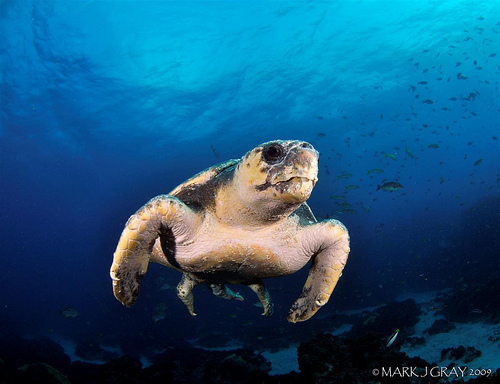

In [7]:
img_path = '../ACE/ImageNet/random500_49/n01664065_30184.JPEG'
img = image.load_img(img_path)
img

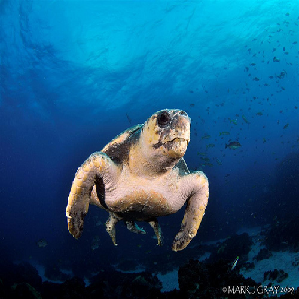

In [8]:
img_resized = image.load_img(img_path, target_size=(299, 299))
img_resized

In [15]:
img_array = np.array(img)
x = np.expand_dims(img_array, axis=0)
x = preprocess_input(x)

pred = mymodel.get_predictions(x)
print(decode_predictions(pred, top=5))

AttributeError: 'Model' object has no attribute 'get_predictions'